<a href="https://colab.research.google.com/github/ham952/ViT/blob/main/ViT_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

### Parameters

In [23]:
BATCH_SIZE = 512
EPOCHS = 20 # Try increasing epochs to 30
LEARNING_RATE = 3e-4
PATCH_SIZE = 4  # P
NUM_CLASSES = 10  # CIFAR-10
IMAGE_SIZE = 32 # Transform the image and make the size go to 224
CHANNELS = 3
EMBED_DIM = 256 # or 512 # E
NUM_HEADS = 8 # INcrease the number heads
DEPTH = 6 # transformer blocks
MLP_DIM = 512
DROP_RATE = 0.1
# num_patches = (IMAGE_SIZE // PATCH_SIZE) ** 2 : 64 # N
# x shape: torch.Size([512, 3, 32, 32])

### Dataset

In [3]:
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(15),  # Random rotation for training data
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
train_dataset = datasets.CIFAR10(root="data",
                                 train= True,
                                 download=True,
                                 transform=train_transform)

val_dataset = datasets.CIFAR10(root="data",
                                 train= True,
                                 download=True,
                                 transform=val_test_transform)

test_dataset = datasets.CIFAR10(root="data",
                                 train= False,
                                 download=True,
                                 transform=val_test_transform)

100%|██████████| 170M/170M [00:02<00:00, 79.2MB/s]


In [5]:
train_dataset = Subset(train_dataset, range(40000))
val_dataset = Subset(val_dataset, range(40000, len(val_dataset)))

In [6]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            drop_last=True,
                            shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [7]:
# Let's check out what we've created
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of val_loader: {len(val_loader)} batches of {BATCH_SIZE}...")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}...")

num_epochs = 1
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        if batch_idx >= 3:
            break
        print(" Batch index:", batch_idx, end="")
        print(" | Batch size:", y.shape[0], end="")
        print(" | x shape:", x.shape, end="")
        print(" | y shape:", y.shape)

# print("Labels from current batch:", y)

Length of train_loader: 78 batches of 512...
Length of val_loader: 19 batches of 512...
Length of test_loader: 20 batches of 512...
 Batch index: 0 | Batch size: 512 | x shape: torch.Size([512, 3, 32, 32]) | y shape: torch.Size([512])
 Batch index: 1 | Batch size: 512 | x shape: torch.Size([512, 3, 32, 32]) | y shape: torch.Size([512])
 Batch index: 2 | Batch size: 512 | x shape: torch.Size([512, 3, 32, 32]) | y shape: torch.Size([512])


## Finetuning Pretrained Model

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                img_size,
                patch_size,
                in_channels,
                embed_dim):
      super().__init__()

      self.patch_size = patch_size
      self.proj = nn.Conv2d(in_channels= in_channels,
                            out_channels= embed_dim,
                            kernel_size=patch_size,
                            stride = patch_size)
      num_patches = (img_size // patch_size) ** 2
      self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True) # Classification Token
      self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim), requires_grad= True) # 1, N+1, E
      self.dropout = nn.Dropout(p=0.1)

    def forward(self, x:torch.Tensor):
      B = x.size(0)
      x = self.proj(x)  # B, C, IH, IW     --> B, E, IH/P, IW/P                Split image into the patches and embed patches
      x = x.flatten(2).transpose(1, 2) # B, E, IH/P, IW/P --> B, E, (IH/P*IW/P) --> B, E, N --> B, N, E
      cls_tokens = self.cls_token.expand(B, -1, -1) # 1, 1, E --> B, 1, E
      x = torch.cat([cls_tokens, x], dim=1) # B, N+1, E i.e., [512, 65, 256]
      x = x + self.pos_embed # [B, N+1, E] +  [1, N+1, E]
      x = self.dropout(x)
      return x


In [10]:
class MLP(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features,
                             out_features=in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [11]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0] # query, key, value # returns tuple (output, attn_weights)[0]
                                                                          # output = (batch_size, seq_len, embed_dim)
                                                                          # attn_weights = (batch_size, num_heads, seq_len, seq_len)

        x = x + self.mlp(self.norm2(x))
        return x

In [12]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)       # B, N+1, E
        x = self.encoder(x)           # B, N+1, E
        x = self.norm(x)              # B, N+1, E
        cls_token = x[:, 0]           # B, E
        x = self.head(cls_token)      # B, num_classes
        return x

In [13]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5 # Unormalize our images to be able to plot them with matplotlib
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"

            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

In [16]:
def train(model, loader, optimizer, criterion):

    model.train()

    total_loss, correct = 0, 0

    for x, y in loader:
        # Moving (Sending) our data into the target device
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        # 1. Forward pass (model outputs raw logits)
        out = model(x)
        # 2. Calcualte loss (per batch)
        loss = criterion(out, y)
        # 3. Perform backpropgation
        loss.backward()
        # 4. Perforam Gradient Descent
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    # You have to scale the loss (Normlization step to make the loss general across all batches)
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def validate(model, loader, criterion):
    model.eval()

    total_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def evaluate(model, loader):
    model.eval() # Set the mode of the model into evlauation
    correct = 0
    with torch.inference_mode():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(dim=1) == y).sum().item()
    return correct / len(loader.dataset)

### 1. Loading complete model with weights

Note: The code below still needed the complete model to be loaded first

In [ ]:
model_loaded_full = torch.load('/content/vit.pth', weights_only=False, map_location=device)

In [25]:
model = model_loaded_full
model

In [26]:
model.eval()
with torch.no_grad():
    dummy_input = torch.randn(512, 3, 32, 32)
    output = model(dummy_input)
    print("Output shape:", output.shape)

Output shape: torch.Size([512, 10])


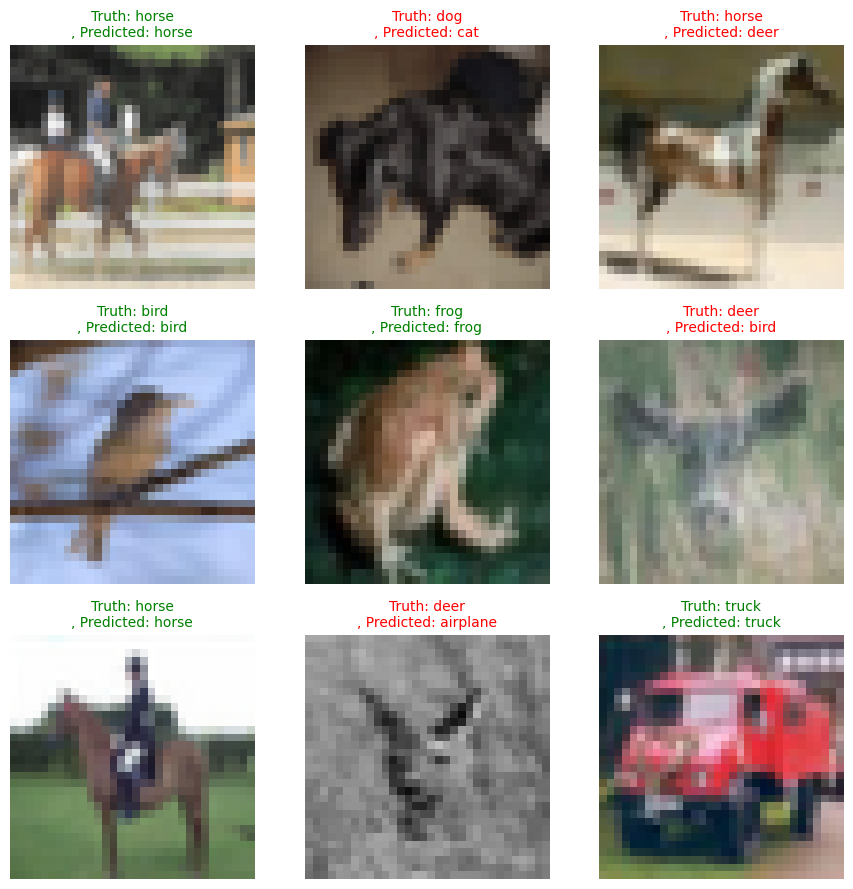

In [32]:
predict_and_plot_grid(model=model,
                      dataset=test_dataset,
                      classes=test_dataset.classes,
                      grid_size=3)

### 2. Loading model weights only

In [27]:
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES, EMBED_DIM, DEPTH, NUM_HEADS,
    MLP_DIM, DROP_RATE).to(device)

In [28]:
model.load_state_dict(torch.load("vit_weights.pth", map_location=device))
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-

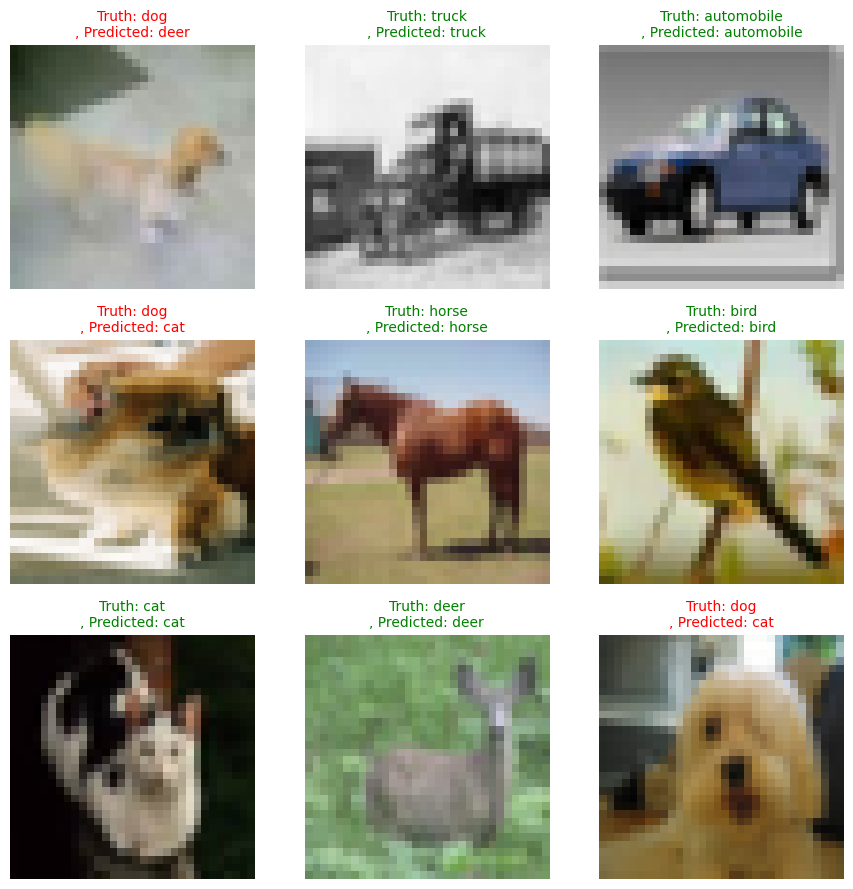

In [17]:
predict_and_plot_grid(model=model,
                      dataset=test_dataset,
                      classes=test_dataset.classes,
                      grid_size=3)

In [18]:
test_acc = evaluate(model, test_loader)
print(f"\n🎯 Final Test Accuracy: {test_acc:.4f}")


🎯 Final Test Accuracy: 0.6257


### 3. Fine Tuning head / Model

In [45]:
pytorch_model= model

In [46]:
pytorch_model.head = nn.Sequential(
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 10)
)

In [47]:
pytorch_model.to(device)  # 👈 do this again after modifying the model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-

In [48]:
print(next(pytorch_model
           .parameters()).device)

cuda:0


In [49]:
# freezing everything else except head
for param in pytorch_model.parameters():
    param.requires_grad = True  # Full model vs only the head

for param in pytorch_model.head.parameters():
    param.requires_grad = True

In [50]:
criterion = nn.CrossEntropyLoss() # Measure how wrong our model is
optimizer = torch.optim.Adam(params=pytorch_model.parameters(), # update our model's parameters to try and reduce the loss
                             lr=LEARNING_RATE)

In [51]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(pytorch_model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(pytorch_model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

Epoch [1/20]
Train Loss: 1.3250, Train Acc: 0.5409
Val   Loss: 1.0888, Val   Acc: 0.5873
Epoch [2/20]
Train Loss: 1.0744, Train Acc: 0.6214
Val   Loss: 1.0550, Val   Acc: 0.6085
Epoch [3/20]
Train Loss: 1.0185, Train Acc: 0.6394
Val   Loss: 1.0261, Val   Acc: 0.6147
Epoch [4/20]
Train Loss: 0.9933, Train Acc: 0.6510
Val   Loss: 1.0253, Val   Acc: 0.6166
Epoch [5/20]
Train Loss: 0.9696, Train Acc: 0.6568
Val   Loss: 1.0288, Val   Acc: 0.6173
Epoch [6/20]
Train Loss: 0.9460, Train Acc: 0.6660
Val   Loss: 1.0218, Val   Acc: 0.6167
Epoch [7/20]
Train Loss: 0.9180, Train Acc: 0.6765
Val   Loss: 1.0211, Val   Acc: 0.6235
Epoch [8/20]
Train Loss: 0.9016, Train Acc: 0.6814
Val   Loss: 1.0280, Val   Acc: 0.6241
Epoch [9/20]
Train Loss: 0.8840, Train Acc: 0.6882
Val   Loss: 1.0112, Val   Acc: 0.6302
Epoch [10/20]
Train Loss: 0.8571, Train Acc: 0.6959
Val   Loss: 1.0003, Val   Acc: 0.6343
Epoch [11/20]
Train Loss: 0.8431, Train Acc: 0.7020
Val   Loss: 1.0002, Val   Acc: 0.6340
Epoch [12/20]
Train

In [52]:
test_acc = evaluate(pytorch_model, test_loader)
print(f"\n🎯 Final Test Accuracy: {test_acc:.4f}")


🎯 Final Test Accuracy: 0.6560


## Embeddings Usage for Fine tuning

In [53]:
# Freeze everything
for param in pytorch_model.parameters():
    param.requires_grad = False

# Remove classification head and optional norm
pytorch_model.norm = nn.Identity()
pytorch_model.head = nn.Identity()
pytorch_model.eval()

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-

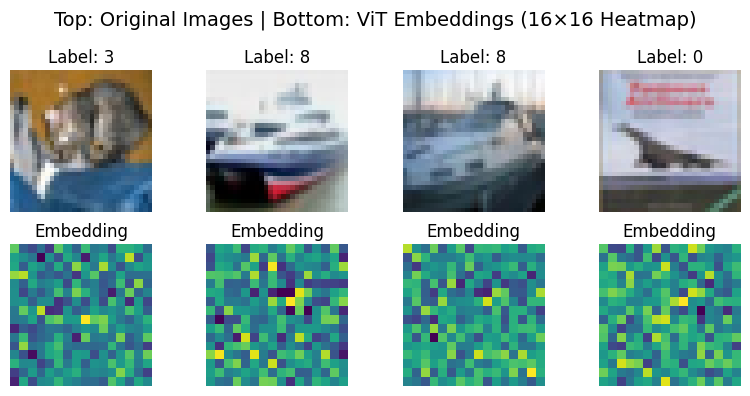

In [65]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Unnormalize function (adjust if your transform is different)
def unnormalize(img_tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return img_tensor * std + mean

# Get one batch of test images
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

# Pass through frozen ViT (head = nn.Identity(), norm = Identity or not)
pytorch_model.eval()
with torch.no_grad():
    embeddings = pytorch_model(images)  # shape: [BATCH_SIZE, 256]

# How many images to visualize
n = 4
plt.figure(figsize=(n * 2, 4))

for i in range(n):
    # ---- ORIGINAL IMAGE ----
    plt.subplot(2, n, i + 1)
    img = unnormalize(images[i].cpu())
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(np.clip(img, 0, 1))
    plt.axis('off')
    plt.title(f"Label: {labels[i].item()}")

    # ---- EMBEDDING HEATMAP ----
    plt.subplot(2, n, i + 1 + n)
    emb = embeddings[i].detach().cpu().numpy().reshape(16, 16)
    plt.imshow(emb, cmap='viridis')
    plt.axis('off')
    plt.title("Embedding")

plt.suptitle("Top: Original Images | Bottom: ViT Embeddings (16×16 Heatmap)", fontsize=14)
plt.tight_layout()
plt.show()


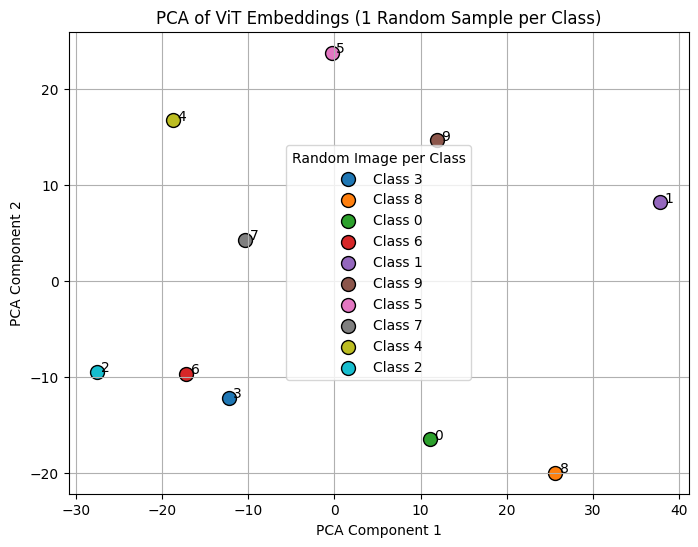

In [73]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
import random

# Ensure randomness per run
random.seed()

# Step 1: Group image indices by class
class_to_indices = defaultdict(list)

for idx in range(len(test_dataset)):
    _, label = test_dataset[idx]
    class_to_indices[label].append(idx)

# Step 2: Randomly pick one index per class
selected_indices = [random.choice(indices) for indices in class_to_indices.values()]

# Step 3: Create a Subset loader with selected images
subset = Subset(test_dataset, selected_indices)
subset_loader = DataLoader(subset, batch_size=len(selected_indices), shuffle=False)

# Step 4: Get embeddings for the selected images
pytorch_model.eval()
with torch.no_grad():
    for x, y in subset_loader:
        x, y = x.to(device), y.to(device)
        embeddings = pytorch_model(x)  # assuming head = nn.Identity()

# Step 5: PCA
embeddings_np = embeddings.cpu().numpy()
labels_np = y.cpu().numpy()

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings_np)

# Step 6: Plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(labels_np):
    plt.scatter(reduced[i, 0], reduced[i, 1], label=f"Class {label}", s=100, edgecolors='k')
    plt.text(reduced[i, 0] + 0.5, reduced[i, 1], str(label), fontsize=10)

plt.legend(title="Random Image per Class")
plt.title("PCA of ViT Embeddings (1 Random Sample per Class)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


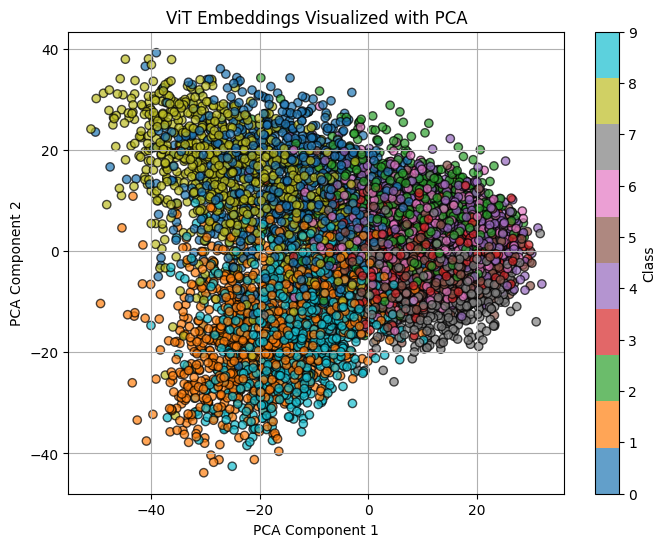

In [66]:
# PCA on embeddings

import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pytorch_model.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        emb = pytorch_model(x)  # assumes model.head = nn.Identity()
        all_embeddings.append(emb.cpu())
        all_labels.append(y.cpu())

# Concatenate all batches
all_embeddings = torch.cat(all_embeddings).numpy()  # shape: [N, 256]
all_labels = torch.cat(all_labels).numpy()          # shape: [N]



pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)  # shape: [N, 2]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1],
    c=all_labels, cmap='tab10', alpha=0.7, edgecolors='k'
)
plt.colorbar(scatter, label="Class")
plt.title("ViT Embeddings Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

### Extras

In [54]:
images, labels = next(iter(test_loader))  # 1 batch
images = images.to(device)
labels = labels.to(device)

In [60]:
def unnormalize(img_tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return img_tensor * std + mean

In [56]:
# Extract Embeddings

with torch.no_grad():
    embeddings = pytorch_model(images)  # [BATCH_SIZE, EMBED_DIM]

In [59]:
embeddings.shape

torch.Size([512, 256])

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings.cpu().numpy())


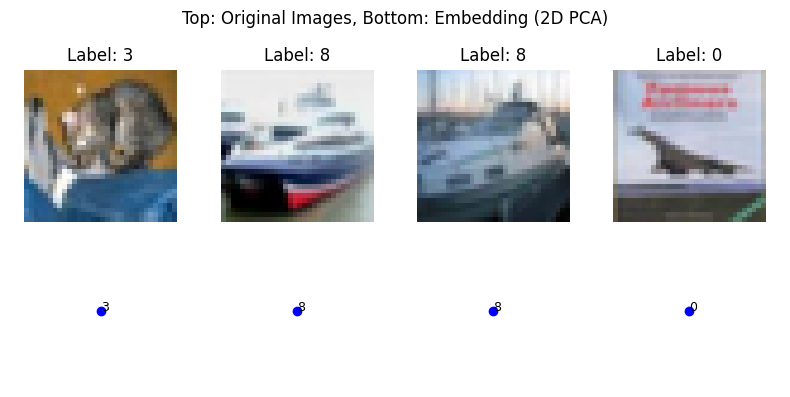

In [63]:
import matplotlib.pyplot as plt

n = 4  # number of samples to show

plt.figure(figsize=(n * 2, 4))

for i in range(n):
    # Image
    plt.subplot(2, n, i + 1)
    img = unnormalize(images[i].cpu())
    img = img.permute(1, 2, 0).numpy()  # CHW -> HWC
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Label: {labels[i].item()}")

    # Embedding
    plt.subplot(2, n, i + 1 + n)
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], c='blue')
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], f"{labels[i].item()}", fontsize=9)
    plt.axis('off')

plt.suptitle("Top: Original Images, Bottom: Embedding (2D PCA)")
plt.tight_layout()
plt.show()


In [76]:
torch.save(pytorch_model.state_dict(), "vit_embeddings_weights.pth")

In [75]:
pytorch_model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-